This code computes the necessary correction to apply to transit spectra due to starspots. It can use both blackbody and phoenix models to model the atmosphere of the sstar and the spots. 

In [1]:
from __future__ import division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.constants import h,c,k
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import convolve, Gaussian1DKernel
from matplotlib import markers
import itertools
%matplotlib notebook

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

In [2]:
#Balackbody model
def spotted_star_model_bb(lam,T_star,T_spot,delta):
    '''
    :params: lam: Array with the wavelengths
    :params: T_star: Temperature of the star in K
    :params: T_spot: Temperature of the spots in K
    :params: delta: Fraction of the spot area
    '''
    
	return (1-delta*(1-blackbody_wav(lam,T_spot)/blackbody_wav(lam,T_star)))

def blackbody_wav(lam,T):
	'''
	Input units lambda (A) and T (K)
	'''

	lam = 1e-10 * lam # convert to metres


	return 2*h*c**2 / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1))

In [3]:
#Phoenix models
def spotted_star_model_phoenix(star_temp,star_log_g,star_meta,spot_temp,delta):
    '''
    :params: star_temp: Temperature of the star
    :params: star_log_g: log_g for the star
    :params: star_meta: Metalicity of the star
    :params: spot_temp: Temeprature of the spots
    :params: delta: Fraction of the spot area
    '''
    wavelength,flux_star = phoenix(star_temp,star_log_g,star_meta)
    wavelength,flux_spot = phoenix(spot_temp,star_log_g,star_meta)
    corre = 1-delta*(1-flux_spot/flux_star)                               
    gauss_kernel = Gaussian1DKernel(2600)
    smoothed_data_gauss = convolve(corre,gauss_kernel)
    return wavelength,smoothed_data_gauss

In [4]:
#Loding the phoenix models
def phoenix(temp, log_g, meta):
    DIR = '../PHOENIX-ACES-AGSS-COND-2011_A1FITS_Z-0.0/'
    DIR = '../Phoenix/'
    
    if temp < 10000:
        temp = '0'+str(temp)
    else: 
        temp = str(temp)
    
    filename_flux = DIR+'Z-'+str(meta)+'/lte'+temp+'-'+str(log_g)+'0-'+str(meta)+'.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    filename_wave = DIR+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
    try:
        flux = fits.open(filename_flux)
        wave = fits.open(filename_wave)
    except:
        print("There is no model with those settings \n T_star = %s \n Metalicity= %f\n log g = %f" %(temp,meta,log_g))
        return 0
    
    header = flux[0].header
    
    wcs = WCS(header)
    index = np.arange(header['NAXIS1'])

    wavelength = wcs.wcs_pix2world(index[:,np.newaxis], 0)
    wavelength = wavelength.flatten()
    wavelength = wave[0].data
    flux = flux[0].data
    
    return wavelength, flux

In [5]:
#Application example

T_star = 5000
deltas_spot = [300,1000]
deltas = [0.02,0.1]
colors = ['blue','orange','red','green']
wavelength_micro = np.linspace(0.01,6,100000)

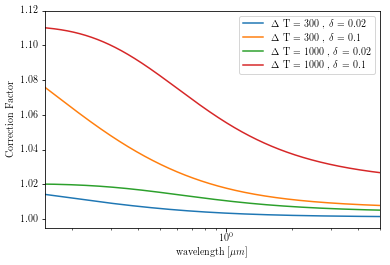

In [6]:
#Plotting the results using blackbody models
n = 0
for delta_spot in deltas_spot:
	T_spot = T_star - delta_spot
	for delta in deltas:
		spectra_correction = 1./spotted_star_model_bb(wavelength_micro*10**4,T_star,T_spot,delta)
		plt.plot(wavelength_micro,spectra_correction,label = r'$\Delta$ T = ' + str(delta_spot) + r'  , $\delta$ = ' + str(delta))#, c = colors[n])
		plt.xscale('log')
		plt.xlabel(r'wavelength [$\mu m$]')
		plt.ylabel('Correction Factor')
		plt.legend()
		plt.xlim(0.15,5)
		plt.ylim(0.995,1.12)
		plt.savefig("Spectra_Correction_bb.png")
		plt.plot()
		n += 1

In [7]:
#Computing the correction using phoenix models
spectras = []
#deltas_T = []
#delta_arr = []
for delta_spot in deltas_spot:
	T_spot = T_star - delta_spot
	for delta in deltas:
		wavelength,spectra_correction = spotted_star_model_phoenix(T_star,4.5,0.0,T_spot,delta)     
		spectra_correction = spectra_correction
		gauss_kernel = Gaussian1DKernel(2600)
		spectra_correction = convolve(spectra_correction, gauss_kernel) #We convolve the spectra to have faster results
		spectras.append(spectra_correction) 
		#delta_arr.append(delta)
		#deltas_T.append(delta_spot)
        

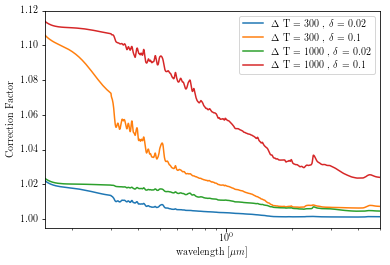

In [8]:
#Plotting the results using blackbody models
i = 0
for delta_spot in deltas_spot:
	T_spot = T_star - delta_spot
	for delta in deltas:
		plt.plot(wavelength/10**4,1./spectras[i],label = r'$\Delta$ T = ' + str(delta_spot) + r'  , $\delta$ = ' + str(delta))
		plt.xscale('log')
		plt.xlabel(r'wavelength [$\mu m$]')
		plt.ylabel('Correction Factor')
		plt.legend()       
		plt.xlim(0.15,5)
		plt.ylim(0.995,1.12)
		plt.savefig("Correction_factor_phoenix.png")
		plt.plot()
		i+=1